In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
import os

In [2]:
def name_dataset(df, name, embedding_type = None, esm_type = None):
    df['dataset'] = name
    if embedding_type is not None:
        df['embedding_type'] = embedding_type
    if esm_type is not None:
        df['esm_type'] = esm_type
    return df

def left_join_hie(df):
    # Read the file
    comparison = {'dataset': ['jones', 'stiffler', 'haddox', 'doud', 'lee', 'kelsic', 'brenan', 'giacomelli', 'markin'],
                  'comparison': [0.22, 0.40, 0.23, 0.16, 0.31, 0.50, 0.077, 0.12, 0.20]}
    comparison = pd.DataFrame(comparison)

    # Merge the two dataframes
    df = pd.merge(df, comparison, on='dataset', how='left')

    return df

comparison = {'dataset': ['jones', 'stiffler', 'haddox', 'doud', 'lee', 'kelsic', 'brenan', 'giacomelli', 'markin'],
              'comparison': [0.22, 0.40, 0.23, 0.16, 0.31, 0.50, 0.077, 0.12, 0.20]}

def read_data(experiment, grid_search_var, columns_to_collapse, esm="esm2", size_csvs = "t48_15B_UR50D"):
    csvs_file_names_list = ["cov2_S", "cas12f", "zikv_E", "kelsic", "brenan", "stiffler", "markin", "giacomelli", "jones", "haddox", "doud", "lee"]

    all_dfs = []

    for file_name in csvs_file_names_list:
        # Attempt to read the file, and if it doesn't exist, skip to the next iteration
        try:
            if size_csvs != "":
                file_path = f"../../grid_search/results/{file_name}_{esm}_{size_csvs}_{experiment}_results.csv"
                individual_df = pd.read_csv(file_path)
            elif size_csvs == "":
                file_path = f"../../grid_search/results/{file_name}_{esm}_{experiment}_results.csv"
                individual_df = pd.read_csv(file_path)                

            # Filter out rows where all columns_to_collapse are None
            individual_df.replace("None", np.nan, inplace=True)
            individual_df = individual_df.dropna(subset=columns_to_collapse, how='all')

            individual_df[columns_to_collapse] = individual_df[columns_to_collapse].apply(pd.to_numeric, errors='coerce')

            # Group by simulation number, grid_search_var, and other columns
            grouped = individual_df.groupby(grid_search_var)

            # Calculate mean and standard deviation for specified columns
            stats = grouped[columns_to_collapse].agg(['mean', 'std'])

            # Flatten multi-index columns
            stats.columns = [f'{col}_{stat}' for col, stat in stats.columns]

            # Reset index to make grouped columns regular columns
            stats.reset_index(inplace=True)

            # Add dataset information
            stats = name_dataset(stats, file_name)

            # Append to list of individual DataFrames
            all_dfs.append(stats)
        except FileNotFoundError:
            print(f"File {file_name}_{esm}_{size_csvs}_{experiment}_results.csv not found. Skipping...")

    # Concatenate all individual DataFrames
    df = pd.concat(all_dfs)

    return df

## One shot comparison

In [3]:
experiment = "one_shot_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "esm2"
size_csvs = "t48_15B_UR50D"

result_df_one_shot = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_one_shot.loc[:, 'label'] = "pre-training: " + result_df_one_shot['num_mutants_per_round'].astype(str) + " mutants"

In [10]:
experiment = "esm2_15B_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "esm2"
size_csvs = "t48_15B_UR50D"

result_df_rounds = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_rounds_subset = result_df_rounds[result_df_rounds['round_num'].isin([5,10])]
result_df_rounds_subset['label'] = "directed evolution: " + result_df_rounds_subset['round_num'].astype(str) + " rounds"

/tmp/ipykernel_3416361/4190193683.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_rounds_subset['label'] = "directed evolution: " + result_df_rounds_subset['round_num'].astype(str) + " rounds"


In [11]:
background = pd.read_csv('/orcd/archive/abugoot/001/Projects/Matteo/Github/directed_evolution/data_processing/background.csv')
background['label']='background'
hie_data_wider = pd.read_csv('/orcd/archive/abugoot/001/Projects/Matteo/Github/directed_evolution/extract/efficient-evolution/hie_dfs_rerun/recommended_wider.csv')
hie_data_wider['label']='efficient-evolution expanded'
hie_data_default = pd.read_csv('/orcd/archive/abugoot/001/Projects/Matteo/Github/directed_evolution/extract/efficient-evolution/hie_dfs_recommended/recommended.csv')   
hie_data_default['label']='efficient-evolution default'

In [12]:
background, hie_data_default, hie_data_wider

(       dataset  fitness_binary_percentage_mean       label
 0        jones                        0.117179  background
 1     stiffler                        0.078947  background
 2       haddox                        0.058151  background
 3         doud                        0.060190  background
 4          lee                        0.066394  background
 5       kelsic                        0.222953  background
 6       brenan                        0.011307  background
 7   giacomelli                        0.121509  background
 8       markin                        0.033622  background
 9       cas12f                        0.180811  background
 10      zikv_E                        0.036650  background
 11      cov2_S                        0.118428  background,
       dataset  fitness_binary_percentage_mean                        label
 0       jones                        0.222222  efficient-evolution default
 1    stiffler                        0.400000  efficient-evolution

In [13]:
concatenated_df_one_shot = pd.concat([result_df_rounds_subset, result_df_one_shot, hie_data_wider, hie_data_default, background], ignore_index=True)

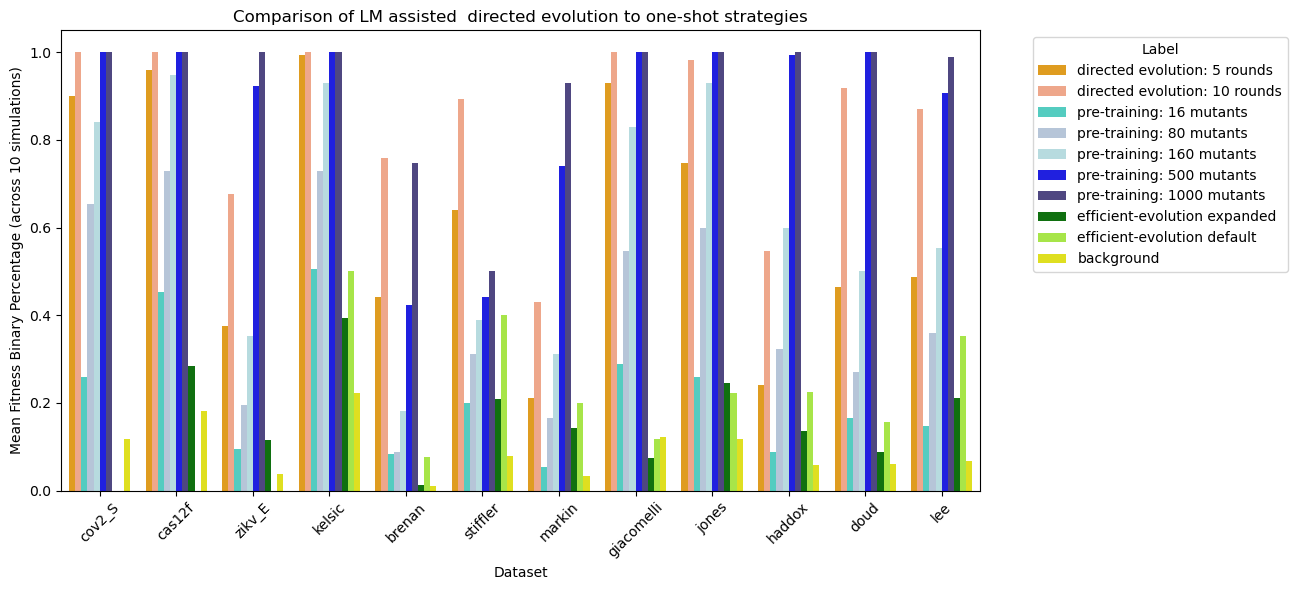

In [15]:
# Define the colors for each hue level
palette_colors = {'efficient-evolution expanded': 'green',
                  'efficient-evolution default': 'greenyellow', 
                  'background': 'yellow', 
                  
                  'pre-training: 16 mutants': 'turquoise', 
                  'pre-training: 80 mutants': 'lightsteelblue',
                  'pre-training: 160 mutants': 'powderblue',
                  'pre-training: 500 mutants': 'blue',
                  'pre-training: 1000 mutants': 'darkslateblue',

                  'directed evolution: 5 rounds': 'orange',
                  'directed evolution: 10 rounds': 'lightsalmon'}

# Create the bar plot with hue and error bars
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=concatenated_df_one_shot, x='dataset', y='fitness_binary_percentage_mean', hue='label', 
            palette=palette_colors)

x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]

# ax.errorbar(x=x_coords, y=y_coords, yerr=concatenated_df["fitness_binary_percentage_std"], fmt="none", capsize=2, c="k")

# Add labels and title
plt.xlabel('Dataset')
plt.ylabel('Mean Fitness Binary Percentage (across 10 simulations)')
plt.title('Comparison of LM assisted  directed evolution to one-shot strategies')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

concatenated_df_one_shot.to_csv("results/one-shot_results.csv", index=False)

/home/md3498/anaconda3/envs/embeddings/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


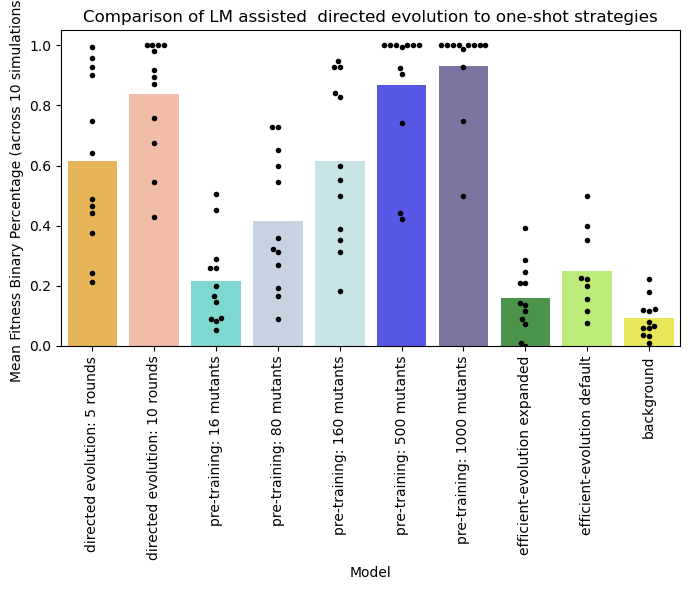

In [16]:
# Define the colors for each hue level
palette_colors = {'efficient-evolution expanded': 'green',
                  'efficient-evolution default': 'greenyellow', 
                  'background': 'yellow', 
                  
                  'pre-training: 16 mutants': 'turquoise', 
                  'pre-training: 80 mutants': 'lightsteelblue',
                  'pre-training: 160 mutants': 'powderblue',
                  'pre-training: 500 mutants': 'blue',
                  'pre-training: 1000 mutants': 'darkslateblue',

                  'directed evolution: 5 rounds': 'orange',
                  'directed evolution: 10 rounds': 'lightsalmon'}


# Create the bar plot
plt.figure(figsize=(7, 6))
ax = sns.barplot(data=concatenated_df_one_shot, x='label', y='fitness_binary_percentage_mean',
                 palette=palette_colors, errorbar = None, alpha = 0.75)

# Overlay underlying points with jitter
sns.swarmplot(data=concatenated_df_one_shot, x='label', y='fitness_binary_percentage_mean', 
              size=4, color = "black")

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Mean Fitness Binary Percentage (across 10 simulations)')
plt.title('Comparison of LM assisted  directed evolution to one-shot strategies')

# Show the plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



## Multiple round comparison (5,10)

In [3]:
experiment = "esm2_15B_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "esm2"
size_csvs = "t48_15B_UR50D"

result_df_15B = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_15B['label'] = "esm2 15B"

In [5]:
experiment = "esm2_3B_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "esm2"
size_csvs = "t36_3B_UR50D"

result_df_3B = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_3B['label'] = "esm2 3B"

In [7]:
experiment = "esm2_650M_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "esm2"
size_csvs = "t33_650M_UR50D"

result_df_650M = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_650M['label'] = "esm2 650M"
result_df_650M.to_csv("results/result_df_rounds_650M.csv", index=False)

In [8]:
experiment = "esm1b_650M_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "esm1b"
size_csvs = "t33_650M_UR50S"

result_df_1b_650M = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_1b_650M['label'] = "esm1b 650M"
result_df_1b_650M.to_csv("results/result_df_rounds_1b_650M.csv", index=False)

File cov2_S_esm1b_t33_650M_UR50S_esm1b_650M_average_results.csv not found. Skipping...


In [9]:
experiment = "esm1v_650M_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "esm1v"
size_csvs = "t33_650M_UR90S_1"

result_df_1v_650M = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_1v_650M['label'] = "esm1v 650M"
result_df_1v_650M.to_csv("results/result_df_rounds_1v_650M.csv", index=False)

File cov2_S_esm1v_t33_650M_UR90S_1_esm1v_650M_average_results.csv not found. Skipping...


In [10]:
experiment = "one-hot_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "one_hot"
size_csvs = "encoded"

result_df_one_hot = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_one_hot['label'] = "one-hot encoded"
result_df_one_hot.to_csv("results/result_df_rounds_one-hot.csv", index=False)

In [11]:
experiment = "integer_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "integer"
size_csvs = "encoded"

result_df_integer = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_integer['label'] = "integer encoded"
result_df_integer.to_csv("results/result_df_rounds_integer.csv", index=False)

In [12]:
experiment = "proteinbert_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "proteinbert"
size_csvs = ""

result_df_proteinbert = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_proteinbert['label'] = "proteinbert"
result_df_proteinbert.to_csv("results/result_df_rounds_proteinbert.csv", index=False)

In [13]:
experiment = "prot_t5_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "prot_t5"
size_csvs = ""

result_df_prot_t5 = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_prot_t5['label'] = "prot t5"
result_df_prot_t5.to_csv("results/result_df_rounds_prot_t5.csv", index=False)

In [14]:
experiment = "ankh_large_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "ankh_large"
size_csvs = ""

result_df_ankh_large = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_ankh_large['label'] = "ankh large"
result_df_ankh_large.to_csv("results/result_df_rounds_ankh_large.csv", index=False)

In [15]:
experiment = "ankh_base_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "ankh_base"
size_csvs = ""

result_df_ankh_base = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_ankh_base['label'] = "ankh base"
result_df_ankh_base.to_csv("results/result_df_rounds_ankh_base.csv", index=False)

In [17]:
experiment = "unirep_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "unirep"
size_csvs = ""

result_df_unirep = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_unirep['label'] = "unirep"
result_df_unirep.to_csv("results/result_df_rounds_unirep.csv", index=False)

In [15]:
concatenated_df = pd.concat([result_df_15B, result_df_3B, result_df_650M, result_df_1b_650M, result_df_1v_650M, 
                             result_df_one_hot, result_df_integer, 
                             result_df_proteinbert, result_df_prot_t5, result_df_ankh_large, result_df_ankh_base, result_df_unirep], ignore_index=True)

concatenated_df_5 = concatenated_df[concatenated_df['round_num'] == 5]
concatenated_df_10 = concatenated_df[concatenated_df['round_num'] == 10]

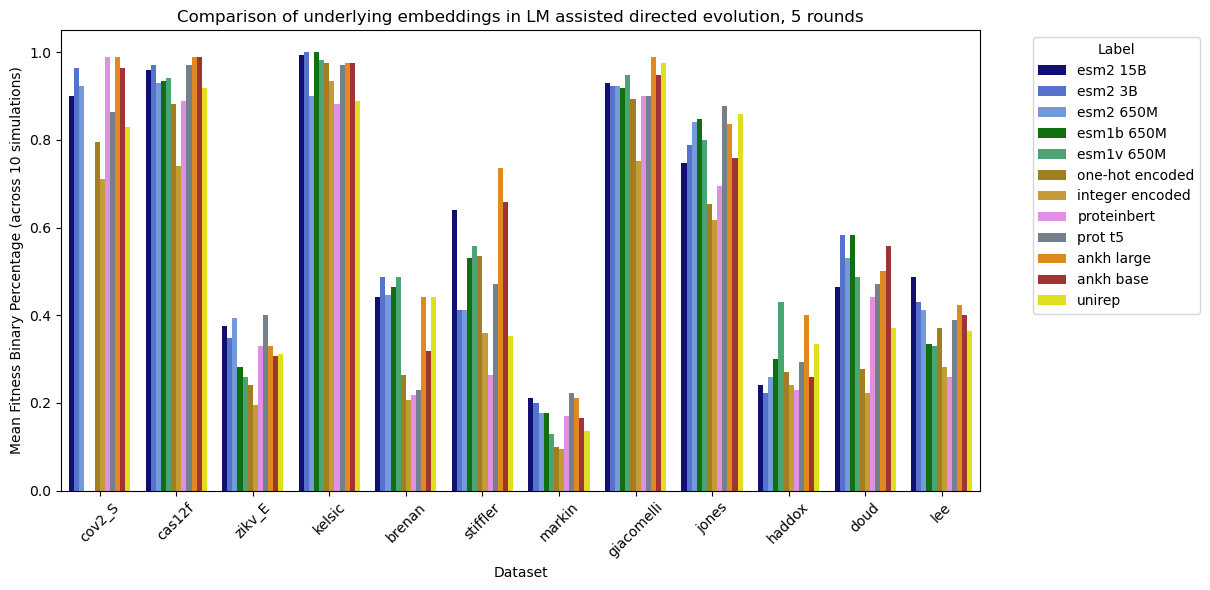

In [16]:
palette_colors = {
    'esm2 15B': 'navy', 
    'esm2 3B': 'royalblue', 
    'esm2 650M': 'cornflowerblue',
    
    'esm1b 650M': 'green',
    'esm1v 650M': 'mediumseagreen',
    
    'one-hot encoded': 'darkgoldenrod',
    'integer encoded': 'goldenrod',
    
    'proteinbert': 'violet',
    
    'prot t5': 'slategrey',      
    
    'ankh large': 'darkorange',    
    'ankh base': 'firebrick',

    'unirep': 'yellow'
}

# Create the bar plot with hue and error bars
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=concatenated_df_5, x='dataset', y='fitness_binary_percentage_mean', hue='label',
            palette=palette_colors)

x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]

# ax.errorbar(x=x_coords, y=y_coords, yerr=concatenated_df["fitness_binary_percentage_std"], fmt="none", capsize=2, c="k")

# Add labels and title
plt.xlabel('Dataset')
plt.ylabel('Mean Fitness Binary Percentage (across 10 simulations)')
plt.title('Comparison of underlying embeddings in LM assisted directed evolution, 5 rounds')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

concatenated_df_5.to_csv("results/5_rounds_results.csv", index=False)

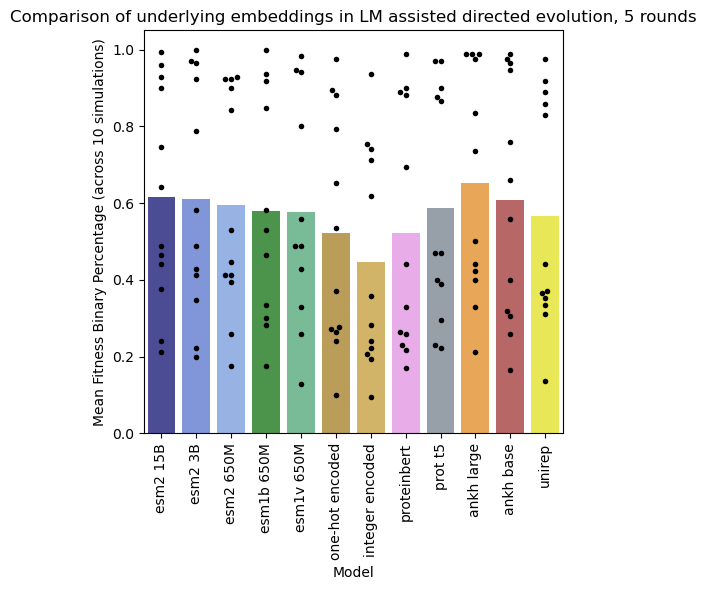

In [17]:
palette_colors = {
    'esm2 15B': 'navy', 
    'esm2 3B': 'royalblue', 
    'esm2 650M': 'cornflowerblue',
    
    'esm1b 650M': 'green',
    'esm1v 650M': 'mediumseagreen',
    
    'one-hot encoded': 'darkgoldenrod',
    'integer encoded': 'goldenrod',
    
    'proteinbert': 'violet',
    
    'prot t5': 'slategrey',      
    
    'ankh large': 'darkorange',    
    'ankh base': 'firebrick',

    'unirep': 'yellow'
}

# Create the bar plot
plt.figure(figsize=(5, 6))
ax = sns.barplot(data=concatenated_df_5, x='label', y='fitness_binary_percentage_mean',
                 palette=palette_colors, errorbar = None, alpha = 0.75)

# Overlay underlying points with jitter
sns.swarmplot(data=concatenated_df_5, x='label', y='fitness_binary_percentage_mean', 
              size=4, color = "black")

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Mean Fitness Binary Percentage (across 10 simulations)')
plt.title('Comparison of underlying embeddings in LM assisted directed evolution, 5 rounds')

# Show the plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

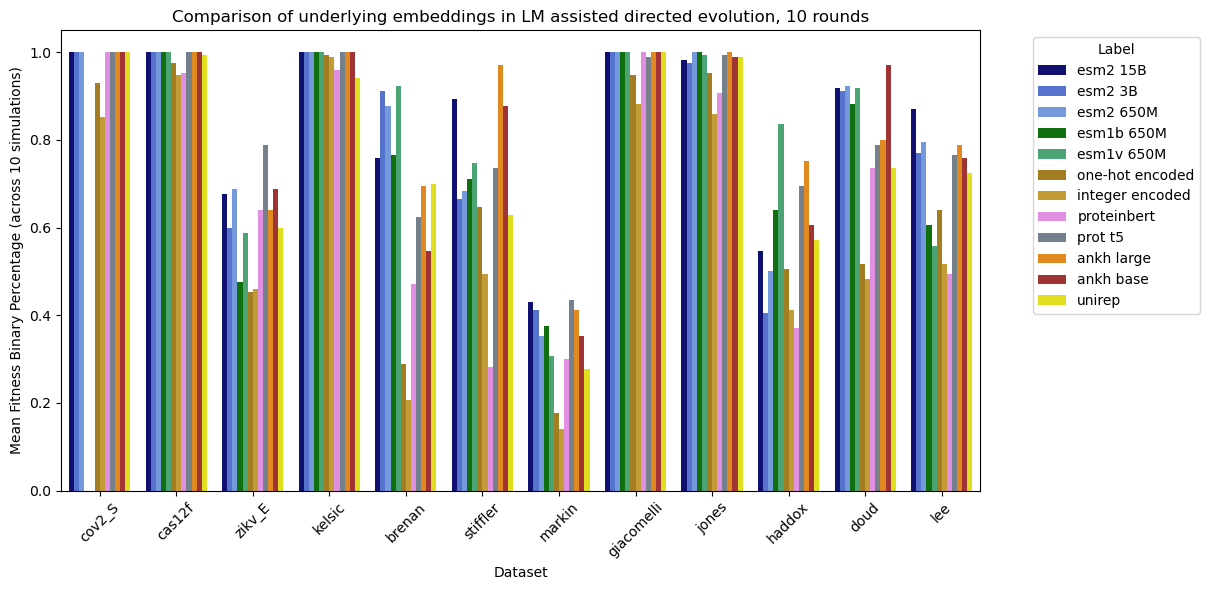

In [18]:
palette_colors = {
    'esm2 15B': 'navy', 
    'esm2 3B': 'royalblue', 
    'esm2 650M': 'cornflowerblue',
    
    'esm1b 650M': 'green',
    'esm1v 650M': 'mediumseagreen',
    
    'one-hot encoded': 'darkgoldenrod',
    'integer encoded': 'goldenrod',
    
    'proteinbert': 'violet',
    
    'prot t5': 'slategrey',      
    
    'ankh large': 'darkorange',    
    'ankh base': 'firebrick',

    'unirep': 'yellow'
}

# Create the bar plot with hue and error bars
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=concatenated_df_10, x='dataset', y='fitness_binary_percentage_mean', hue='label',
            palette=palette_colors)

x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]

# ax.errorbar(x=x_coords, y=y_coords, yerr=concatenated_df["fitness_binary_percentage_std"], fmt="none", capsize=2, c="k")

# Add labels and title
plt.xlabel('Dataset')
plt.ylabel('Mean Fitness Binary Percentage (across 10 simulations)')
plt.title('Comparison of underlying embeddings in LM assisted directed evolution, 10 rounds')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

concatenated_df_10.to_csv("results/10_rounds_results.csv", index=False)

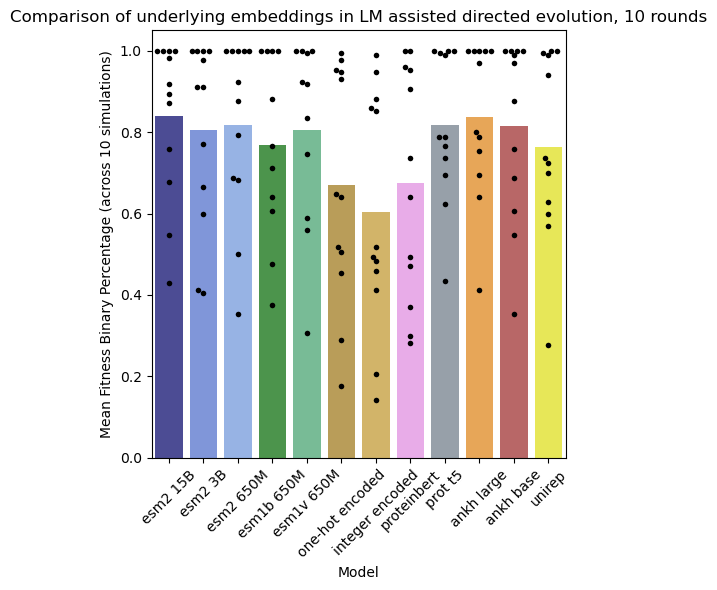

In [19]:
palette_colors = {
    'esm2 15B': 'navy', 
    'esm2 3B': 'royalblue', 
    'esm2 650M': 'cornflowerblue',
    
    'esm1b 650M': 'green',
    'esm1v 650M': 'mediumseagreen',
    
    'one-hot encoded': 'darkgoldenrod',
    'integer encoded': 'goldenrod',
    
    'proteinbert': 'violet',
    
    'prot t5': 'slategrey',      
    
    'ankh large': 'darkorange',    
    'ankh base': 'firebrick',

    'unirep': 'yellow'
}

# Create the bar plot
plt.figure(figsize=(5, 6))
ax = sns.barplot(data=concatenated_df_10, x='label', y='fitness_binary_percentage_mean',
                 palette=palette_colors, errorbar = None, alpha = 0.75)

# Overlay underlying points with jitter
sns.swarmplot(data=concatenated_df_10, x='label', y='fitness_binary_percentage_mean', 
              size=4, color = "black")

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Mean Fitness Binary Percentage (across 10 simulations)')
plt.title('Comparison of underlying embeddings in LM assisted directed evolution, 10 rounds')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Grid search comparison

In [3]:
experiment = "esm2_15B_full_grid_search_distributed_average"
grid_search_var = ["num_mutants_per_round", "round_num", "first_round_strategy", "measured_var", "learning_strategy", "regression_type", "embedding_type"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "esm2"
size_csvs = "t48_15B_UR50D"

result_df_grid_search_15B = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_grid_search_15B_5 = result_df_grid_search_15B[result_df_grid_search_15B['round_num'] == 5]
result_df_grid_search_15B_10 = result_df_grid_search_15B[result_df_grid_search_15B['round_num'] == 10]

In [4]:
result_df_grid_search_15B_5.to_csv("results/grid_search_5_rounds_results.csv", index=False)
result_df_grid_search_15B_10.to_csv("results/grid_search_10_rounds_results.csv", index=False)

In [61]:
def plot_grid_search_var(df, strategy_column='first_round_strategy'):
    # Extract round number
    round_num = df['round_num'].iloc[0]

    # Group by dataset and strategy column, calculate mean of fitness_binary_percentage_mean
    grouped = df.groupby(['dataset', strategy_column])['fitness_binary_percentage_mean'].mean().unstack()

    # Plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df, x='dataset', y='fitness_binary_percentage_mean', hue=strategy_column, errorbar=None, alpha=0.75)
    ax.set_title(f'Fitness binary percentage mean by "{strategy_column.replace("_", " ")}" ({round_num} rounds)')
    ax.set_xlabel('Dataset')
    ax.set_ylabel('Fitness Binary Percentage Mean')
    ax.legend(title=strategy_column.capitalize(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Count the occurrences of each strategy being the best for each dataset
    winning_counts = grouped.apply(lambda x: x.idxmax(), axis=1).value_counts()

    # Print counts of winning strategies
    print("\nCounts of Winning Strategies:")
    print(winning_counts)

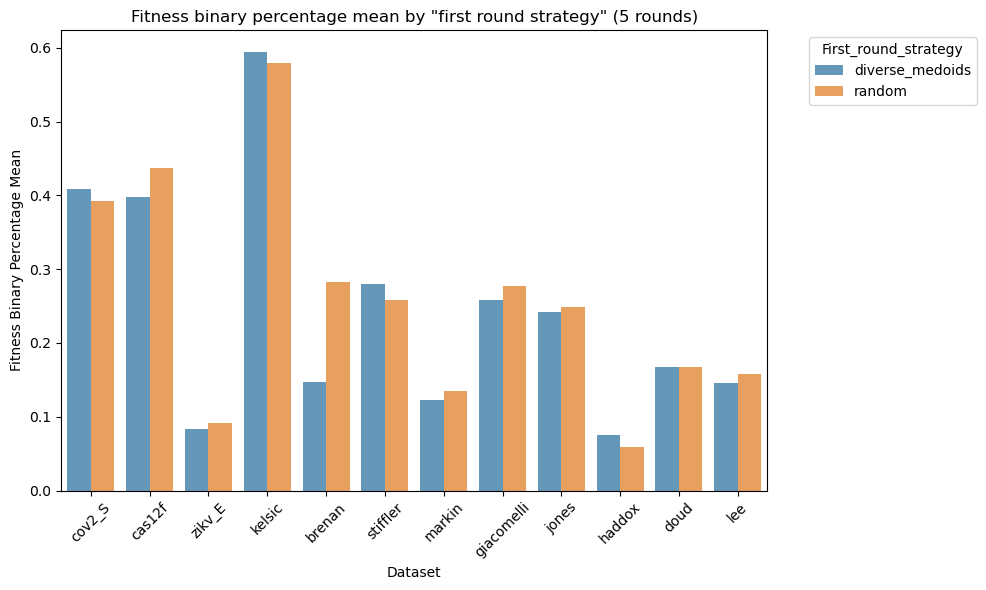


Counts of Winning Strategies:
random             8
diverse_medoids    4
dtype: int64


In [62]:
plot_grid_search_var(result_df_grid_search_15B_5, strategy_column='first_round_strategy')

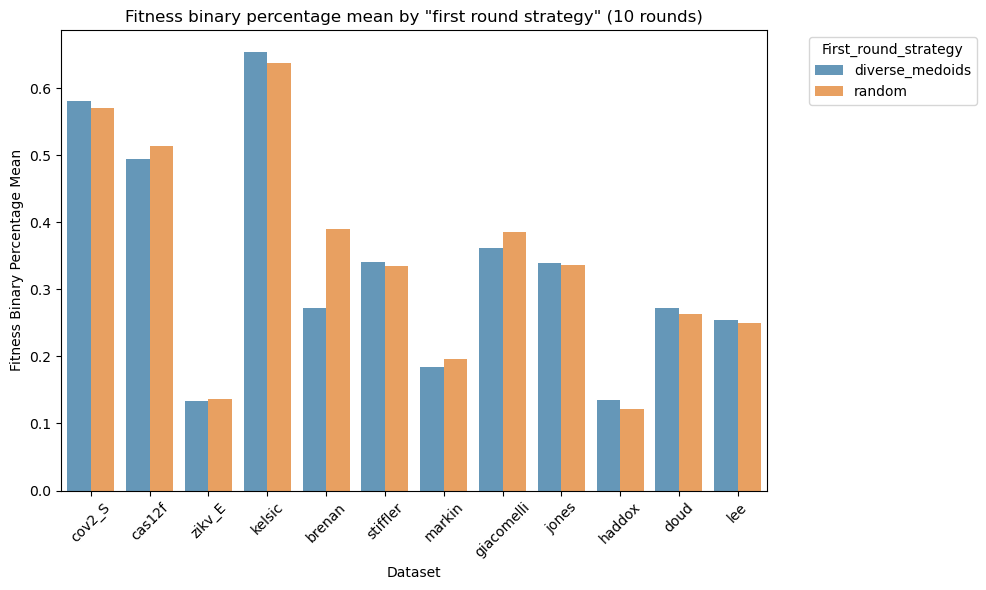


Counts of Winning Strategies:
diverse_medoids    7
random             5
dtype: int64


In [63]:
plot_grid_search_var(result_df_grid_search_15B_10, strategy_column='first_round_strategy')

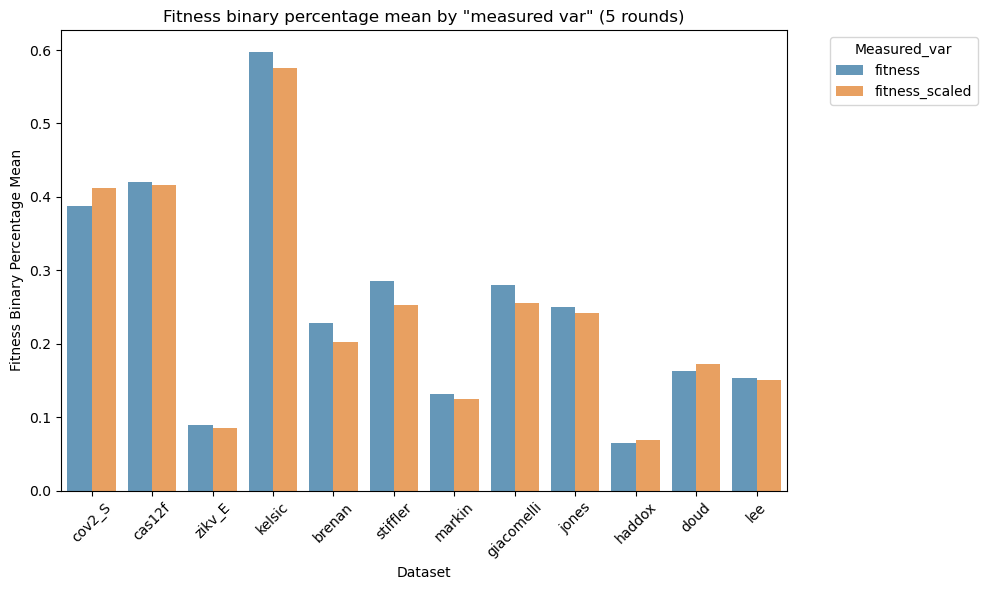


Counts of Winning Strategies:
fitness           9
fitness_scaled    3
dtype: int64


In [64]:
plot_grid_search_var(result_df_grid_search_15B_5, strategy_column='measured_var')

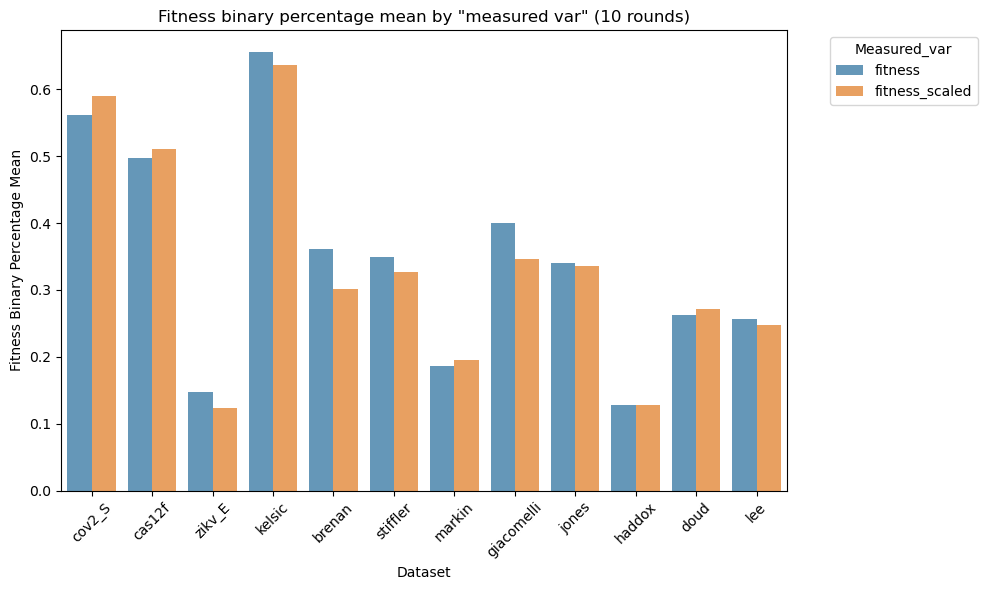


Counts of Winning Strategies:
fitness           7
fitness_scaled    5
dtype: int64


In [65]:
plot_grid_search_var(result_df_grid_search_15B_10, strategy_column='measured_var')

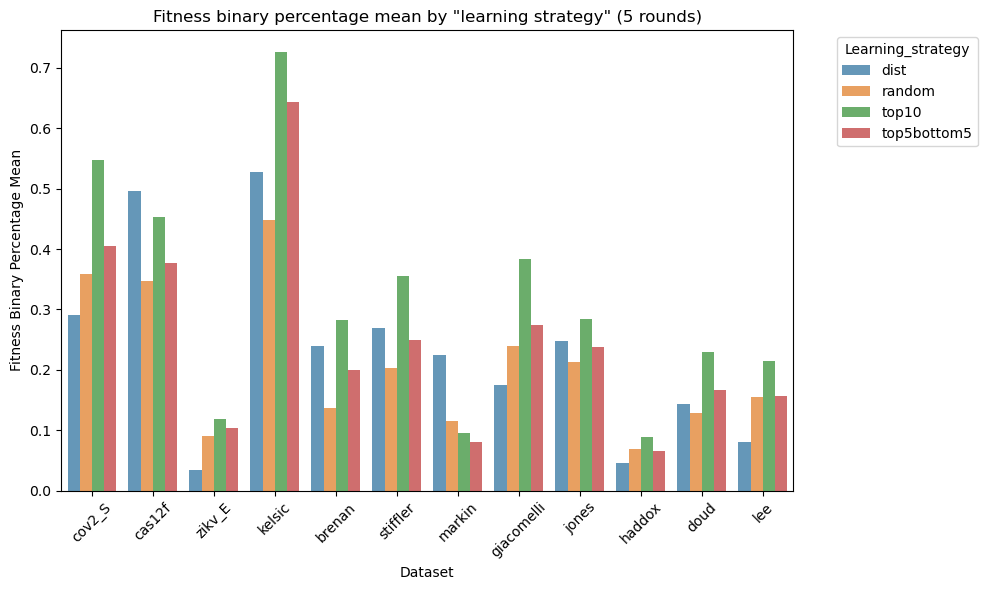


Counts of Winning Strategies:
top10    10
dist      2
dtype: int64


In [66]:
plot_grid_search_var(result_df_grid_search_15B_5, strategy_column='learning_strategy')

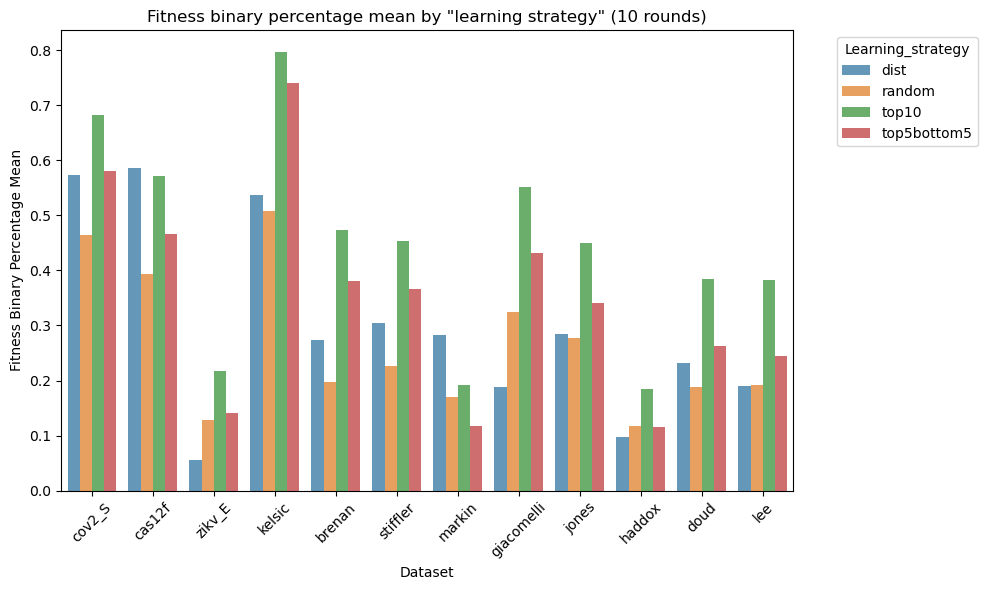


Counts of Winning Strategies:
top10    10
dist      2
dtype: int64


In [67]:
plot_grid_search_var(result_df_grid_search_15B_10, strategy_column='learning_strategy')

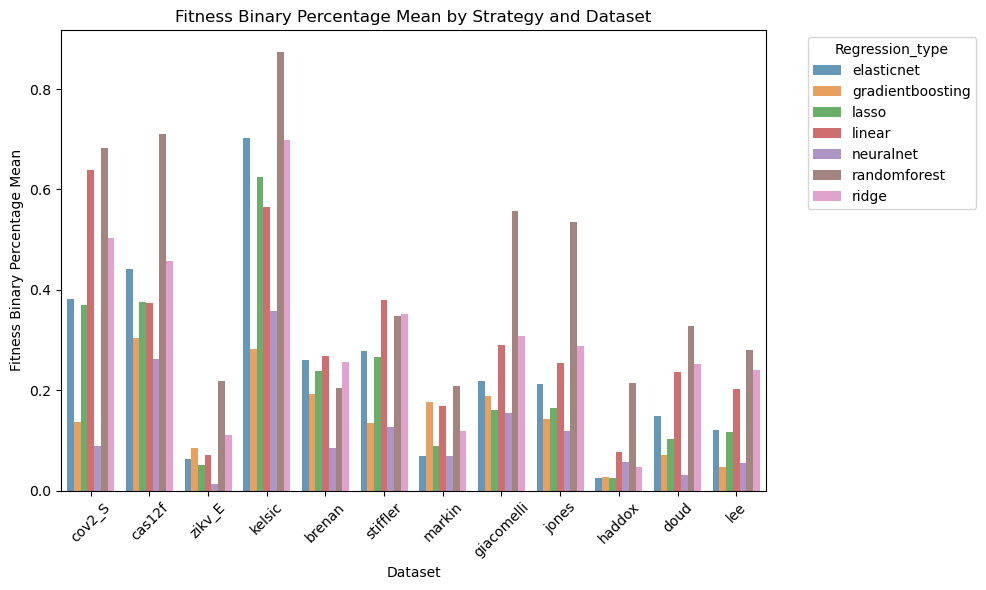


Counts of Winning Strategies:
randomforest    10
linear           2
dtype: int64


In [54]:
plot_grid_search_var(result_df_grid_search_15B_5, strategy_column='regression_type')

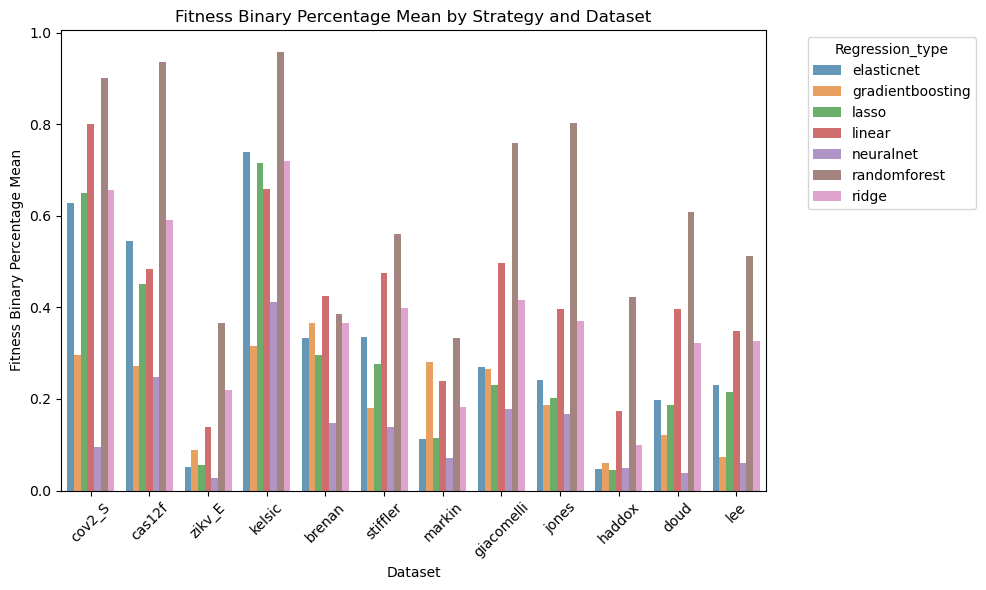


Counts of Winning Strategies:
randomforest    11
linear           1
dtype: int64


In [55]:
plot_grid_search_var(result_df_grid_search_15B_10, strategy_column='regression_type')

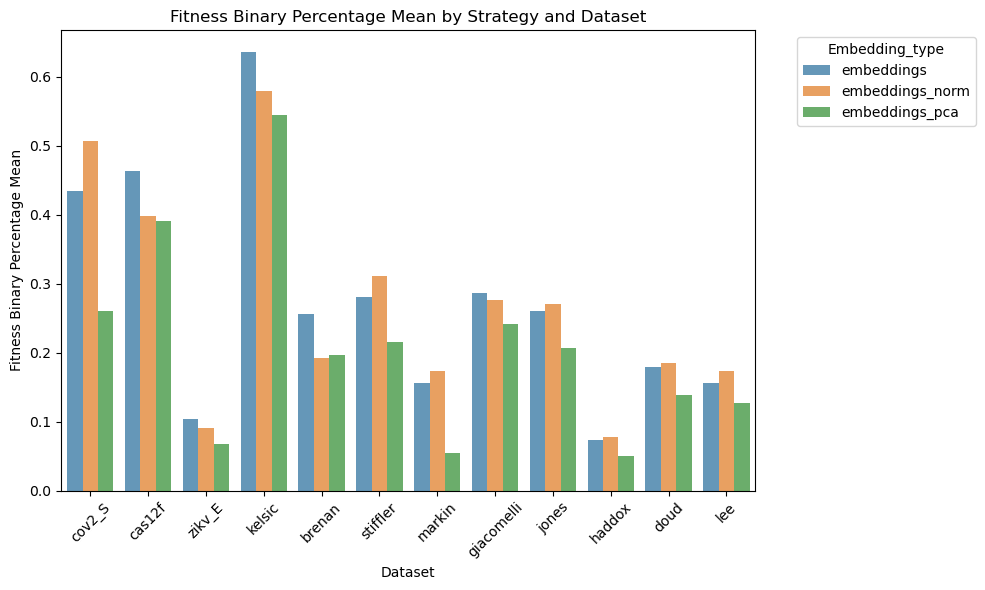


Counts of Winning Strategies:
embeddings_norm    7
embeddings         5
dtype: int64


In [56]:
plot_grid_search_var(result_df_grid_search_15B_5, strategy_column='embedding_type')

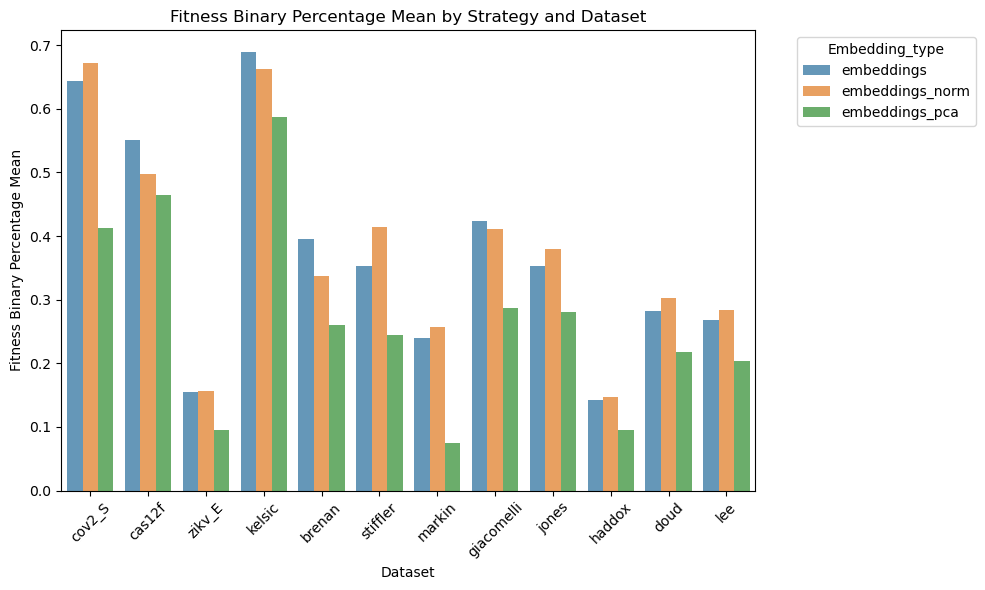


Counts of Winning Strategies:
embeddings_norm    8
embeddings         4
dtype: int64


In [57]:
plot_grid_search_var(result_df_grid_search_15B_10, strategy_column='embedding_type')

## Across rounds comparison

In [6]:
# make a color map dictionary for datasets
datasets = ['jones', 'stiffler', 'haddox', 'doud', 'lee', 'kelsic', 'brenan', 'giacomelli', 'markin', "cov2_S", "cas12f", "zikv_E"]
color_map = {dataset: plt.cm.tab20(i) for i, dataset in enumerate(datasets)}

# show the colors of the color map
for dataset in datasets:
    print(dataset, color_map[dataset])

def plot_round_by_round_comparison(df, output_var, error_var, ax = None, comparison=False):
    if ax is None:
        plt.figure(figsize=(10, 6))
        ax = plt.gca()

    # Left join the comparison values
    df = left_join_hie(df)

    # Create a color map for datasets
    datasets = df['dataset'].unique()

    # Plot each dataset and embedding type as a separate line
    for i, dataset in enumerate(datasets):
        dataset_df = df[(df['dataset'] == dataset)]
        x_values = dataset_df['round_num']
        y_values = dataset_df[output_var]
        error_values = dataset_df[error_var]
        y_value_min = y_values - error_values
        y_value_max = y_values + error_values
        color = color_map[dataset]  # Corrected line

        # Plot the line with error bars
        ax = sns.lineplot(x=x_values, y=y_values, ax=ax, marker='o', color=color, label=dataset)
        # ax.fill_between(x_values, y_value_min, y_value_max, alpha=0.2)
        # ax.errorbar(x=x_values, y=y_values, yerr=error_values, fmt="none", capsize=2, c="k")

        if comparison:
            comparisons = dataset_df['comparison']
            for k, comparison_value in enumerate(comparisons):
                if not np.isnan(comparison_value):
                    # Create an interpolation function for the line
                    line_interp = interp1d(x_values, y_values, kind='linear', fill_value='extrapolate')
    
                    # Find the intersection point with the comparison value
                    intersection_x = np.interp(comparison_value, y_values, x_values)
                    intersection_y = line_interp(intersection_x)
    
                    # Plot the dash marker at the intersection point
                    ax.scatter(intersection_x, intersection_y, color='black', s=200, marker='_', zorder=5, label='_nolegend_')
    
    # Add labels and title
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel(output_var.replace('_', ' ').title())
    ax.set_title(f'{output_var.replace("_", " ").title()} by Iterations')
    
    # Show the legend
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Show the plot
    plt.show()

jones (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)
stiffler (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0)
haddox (1.0, 0.4980392156862745, 0.054901960784313725, 1.0)
doud (1.0, 0.7333333333333333, 0.47058823529411764, 1.0)
lee (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)
kelsic (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0)
brenan (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)
giacomelli (1.0, 0.596078431372549, 0.5882352941176471, 1.0)
markin (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0)
cov2_S (0.7725490196078432, 0.6901960784313725, 0.8352941176470589, 1.0)
cas12f (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)
zikv_E (0.7686274509803922, 0.611764705882353, 0.5803921568627451, 1.0)


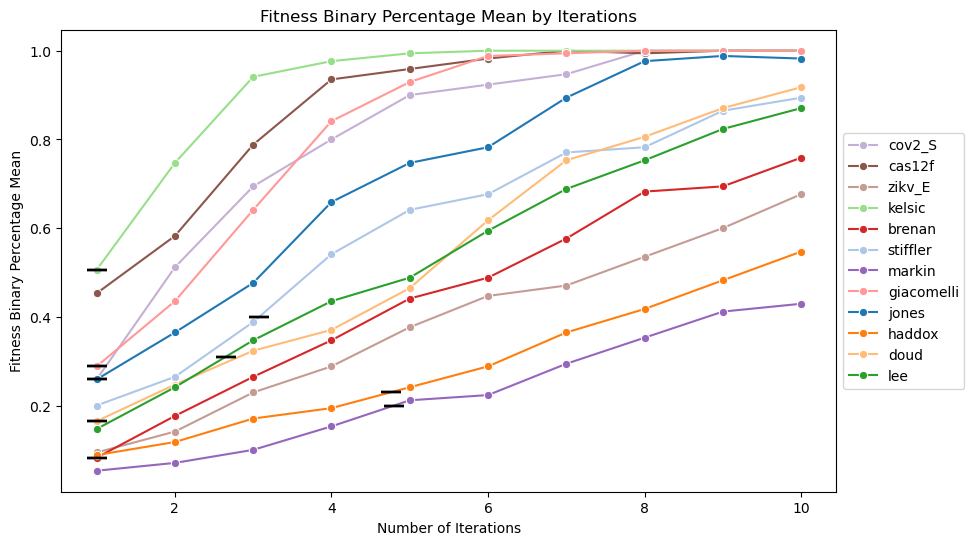

In [11]:
plot_round_by_round_comparison(result_df_rounds, 'fitness_binary_percentage_mean', 'fitness_binary_percentage_std', comparison=True)

In [26]:
result_df_rounds.to_csv("results/result_df_rounds_15B.csv")

## Across rounds comparison (number of mutants per round)

In [25]:
experiment = "esm2_15B_num_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "esm2"
size_csvs = "t48_15B_UR50D"

result_df_num = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)
result_df_num.to_csv("results/result_df_num_15B.csv")

In [26]:
result_df_num

,num_mutants_per_round,round_num,median_fitness_scaled_mean,median_fitness_scaled_std,top_fitness_scaled_mean,top_fitness_scaled_std,fitness_binary_percentage_mean,fitness_binary_percentage_std,dataset
0,10,1,0.029079,0.008763,0.240211,0.067632,0.196078,0.033962,cov2_S
1,10,2,0.136805,0.008297,0.356181,0.073011,0.372549,0.089854,cov2_S
2,10,3,0.180451,0.029682,0.346787,0.077849,0.588235,0.256406,cov2_S
3,10,4,0.224030,0.085697,0.499429,0.179334,0.764706,0.311265,cov2_S
4,10,5,0.313791,0.091058,0.501664,0.175829,0.960784,0.067924,cov2_S
...,...,...,...,...,...,...,...,...,...
75,500,6,0.637360,0.068756,0.892915,0.000000,1.000000,0.000000,lee
76,500,7,0.666477,0.092467,0.892915,0.000000,1.000000,0.000000,lee
77,500,8,0.674127,0.085127,0.892915,0.000000,1.000000,0.000000,lee
78,500,9,0.756477,0.034767,0.892915,0.000000,1.000000,0.000000,lee


In [13]:
# Color map dictionary for datasets
datasets = ['jones', 'stiffler', 'haddox', 'doud', 'lee', 'kelsic', 'brenan', 'giacomelli', 'markin', "cov2_S", "cas12f", "zikv_E"]
color_map = {dataset: plt.cm.tab20(i) for i, dataset in enumerate(datasets)}

# Line style map for num_mutants_per_round
line_styles = {
    10: 'solid', 
    20: 'dotted', 
    30: 'dashed', 
    40: 'dashdot', 
    50: (0, (3, 5, 1, 5)), 
    100: (0, (5, 10)), 
    200: (0, (3, 1, 1, 1)), 
    500: (0, (1, 10))
}

def plot_round_by_round_comparison_num(df, output_var, ax=None, comparison=False):
    if ax is None:
        plt.figure(figsize=(10, 6))
        ax = plt.gca()

    # Plot each dataset and embedding type as a separate line
    for dataset in df['dataset'].unique():
        dataset_df = df[df['dataset'] == dataset]
        for num_mutants in dataset_df['num_mutants_per_round'].unique():
            subset_df = dataset_df[dataset_df['num_mutants_per_round'] == num_mutants]
            x_values = subset_df['round_num']
            y_values = subset_df[output_var]
            color = color_map[dataset]
            line_style = line_styles[num_mutants]

            # Plot the line with error bars
            ax = sns.lineplot(x=x_values, y=y_values, ax=ax, marker='o', color=color, linestyle=line_style, label=f'{dataset} (mutants: {num_mutants})')

    # Add labels and title
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel(output_var.replace('_', ' ').title())
    ax.set_title(f'{output_var.replace("_", " ").title()} by Iterations')

    # Show the legend
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Show the plot
    plt.show()

In [21]:
result_df_num_stiffler = result_df_num[result_df_num['dataset'] == 'stiffler']
result_df_num_lee = result_df_num[result_df_num['dataset'] == 'lee']
result_df_num_doud = result_df_num[result_df_num['dataset'] == 'doud']
result_df_num_brenan = result_df_num[result_df_num['dataset'] == 'brenan']

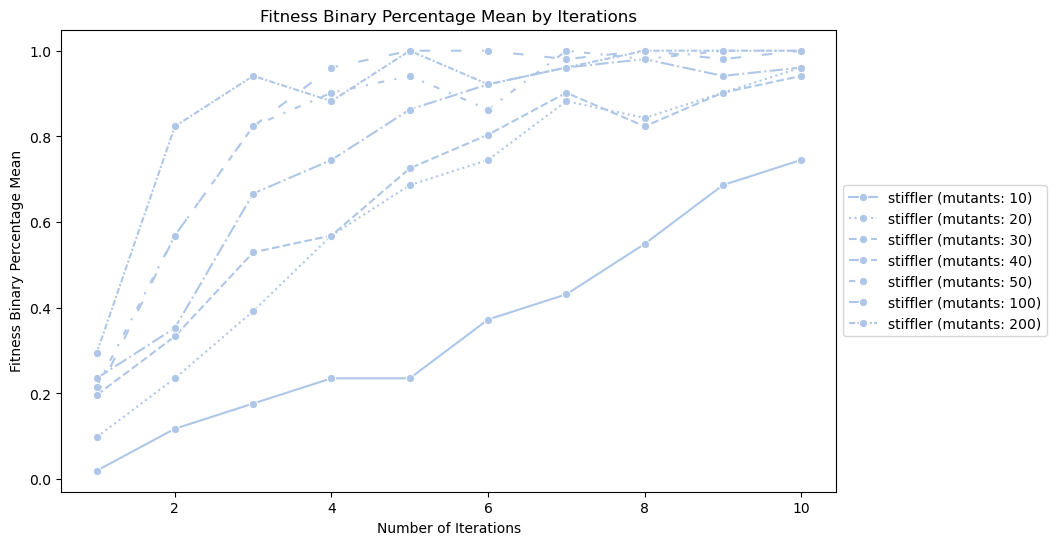

In [19]:
plot_round_by_round_comparison_num(result_df_num_stiffler, 'fitness_binary_percentage_mean')

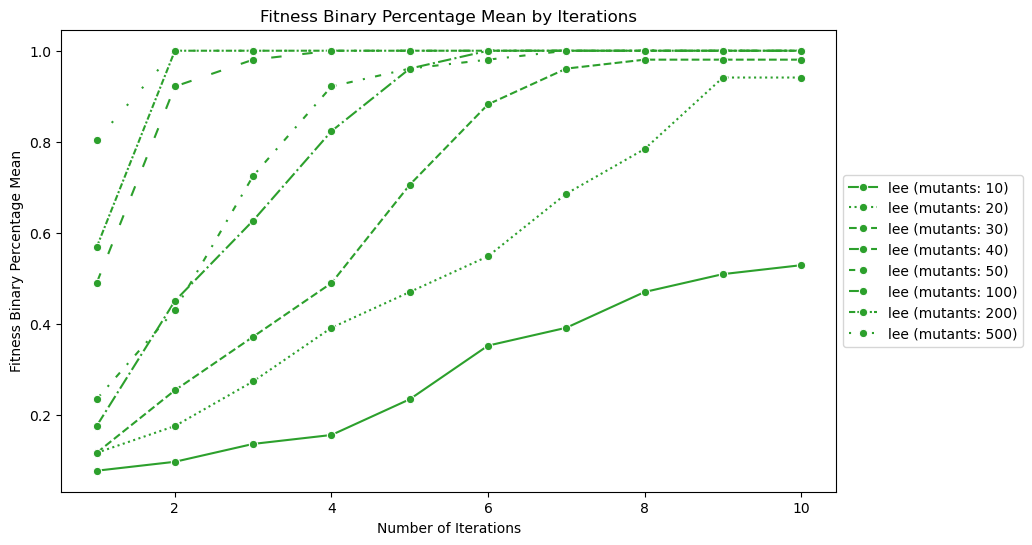

In [22]:
plot_round_by_round_comparison_num(result_df_num_lee, 'fitness_binary_percentage_mean')

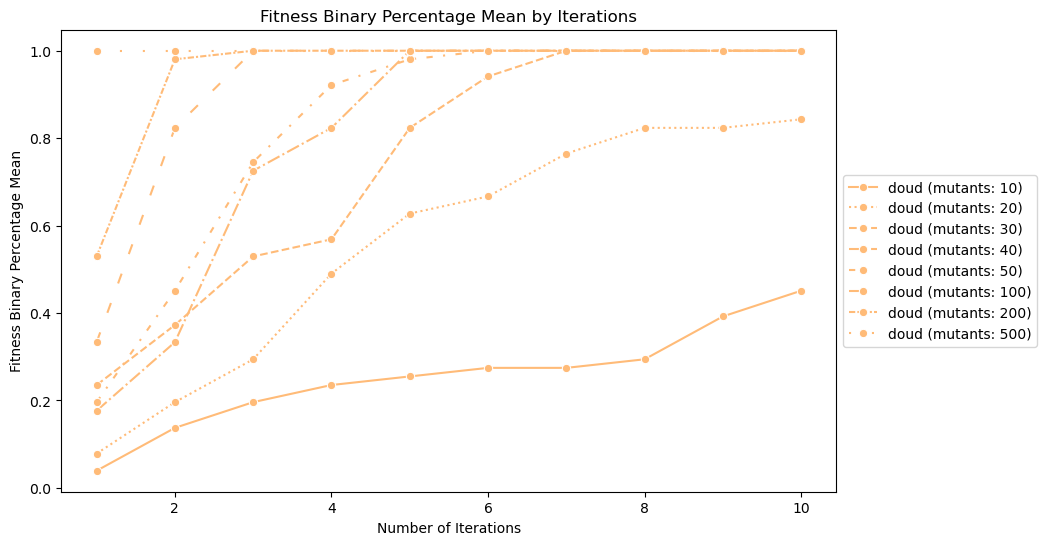

In [23]:
plot_round_by_round_comparison_num(result_df_num_doud, 'fitness_binary_percentage_mean')

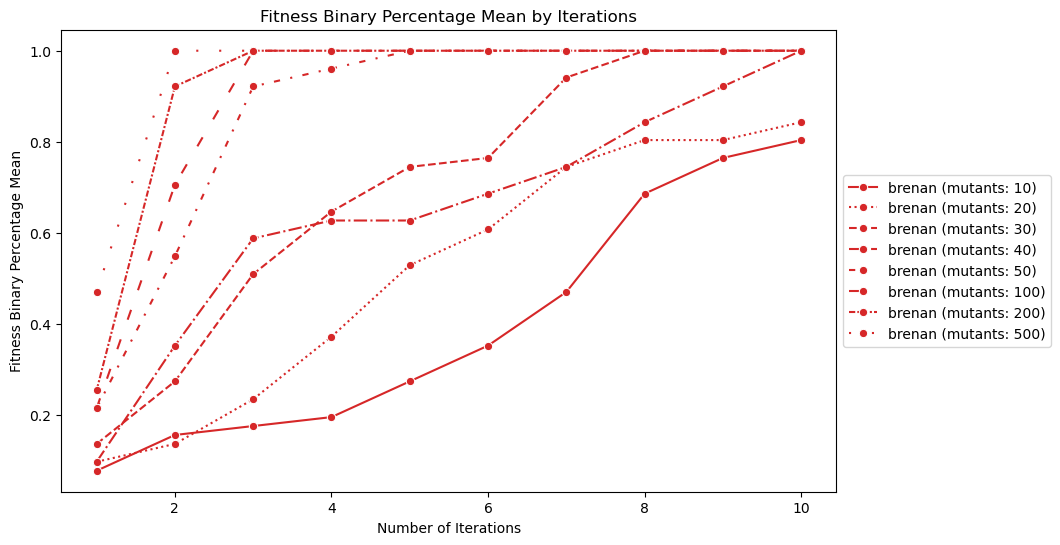

In [24]:
plot_round_by_round_comparison_num(result_df_num_brenan, 'fitness_binary_percentage_mean')

## Pearson correlations

In [3]:
experiment = "esm2_15B_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["spearman_corr"]  # List of columns to collapse
esm = "esm2"
size_csvs = "t48_15B_UR50D"

result_df_rounds = read_data(experiment, grid_search_var, columns_to_collapse, esm, size_csvs)

In [4]:
result_df_rounds

,num_mutants_per_round,round_num,spearman_corr_mean,spearman_corr_std,dataset
0,16,1,0.064492,0.046116,cov2_S
1,16,2,0.132253,0.051638,cov2_S
2,16,3,0.159039,0.080015,cov2_S
3,16,4,0.132580,0.059142,cov2_S
4,16,5,0.154711,0.037296,cov2_S
...,...,...,...,...,...
5,16,6,0.021827,0.046987,lee
6,16,7,0.035352,0.044722,lee
7,16,8,0.046815,0.041955,lee
8,16,9,0.041864,0.053121,lee


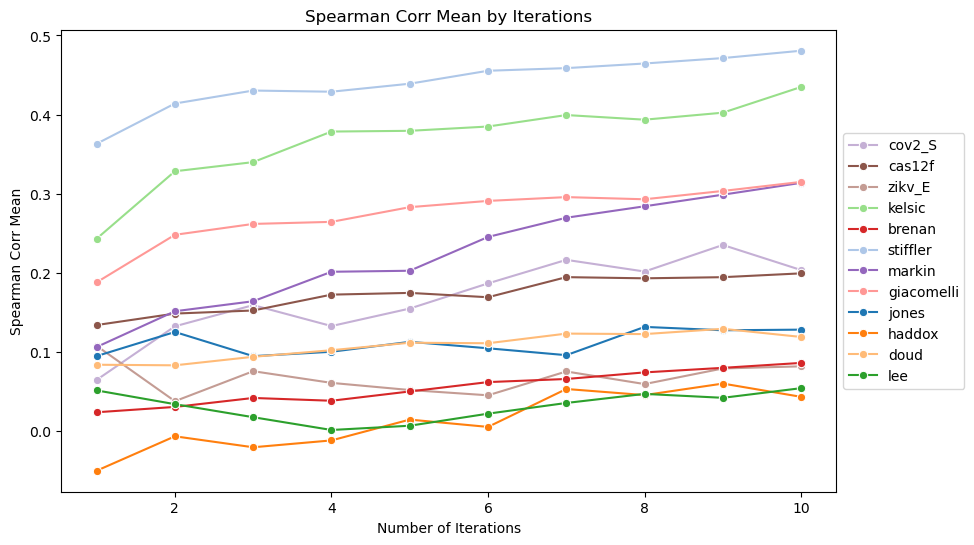

In [7]:
plot_round_by_round_comparison(result_df_rounds, 'spearman_corr_mean', 'spearman_corr_std', comparison=False)

In [8]:
result_df_rounds.to_csv("results/result_df_rounds_15B_spearman_corr.csv")